# Shape Tech-Test

Author: Jonatas Cesar 

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, RocCurveDisplay
from catboost import CatBoostClassifier, Pool
import shap
import pandas
from pandas_profiling import ProfileReport

In [2]:
%matplotlib inline

In [3]:
df = pd.read_excel("O&G Equipment Data.xlsx", index_col = 'Cycle')

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Preset_1,800.0,1.988750,0.805875,1.000000,1.000000,2.000000,3.000000,3.000000
Preset_2,800.0,4.551250,2.293239,1.000000,3.000000,5.000000,7.000000,8.000000
Temperature,800.0,69.263494,25.536252,2.089354,51.040134,65.906716,80.527220,255.607829
Pressure,800.0,78.997945,32.501834,3.480279,55.508564,75.014848,99.302530,189.995681
VibrationX,800.0,73.860275,31.229631,3.846343,50.752461,69.394953,90.195059,230.861142
VibrationY,800.0,72.786878,32.739745,10.057744,48.523982,65.504770,94.075572,193.569947
VibrationZ,800.0,71.866211,27.844616,18.784169,50.787638,69.319237,88.891205,230.951134
Frequency,800.0,68.223449,29.138702,4.380101,45.861762,65.664252,90.097457,178.090303


In [5]:
#check imbalanced data
df.Fail.mean()

0.0825

In [6]:
profile = ProfileReport(df, title="Shape Data - Profiling Report", minimal = True)

In [7]:
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

## Split Data

In [8]:
X, y = df.iloc[:,:-1], df.iloc[:,-1]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Fit 

In [10]:
model = CatBoostClassifier()

In [11]:
cat_features = ['Preset_1', 'Preset_2']

In [62]:
sample_weight_train = compute_sample_weight(class_weight = "balanced", y= y_train)

In [63]:
class_weight = {True : sample_weight_train[~y_train.values][0], False : sample_weight_train[y_train.values][0]}

In [64]:
sample_weight_test = compute_sample_weight(class_weight = class_weight, y= y_test)

In [32]:
model.fit(X_train, y_train, sample_weight=train_sample_weight, cat_features = cat_features, verbose = False);

## Classification perfomance

In [33]:
y_pred_prob = model.predict(X_test, prediction_type = 'Probability')[:,1]

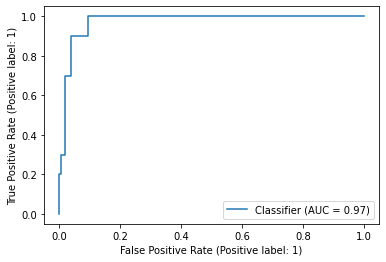

In [65]:
RocCurveDisplay.from_predictions(y_test.values, y_pred_prob, sample_weight=sample_weight_test)
plt.show()

In [66]:
y_pred = y_pred_prob > 0.5

In [67]:
print(classification_report(y_test.values, y_pred))

              precision    recall  f1-score   support

       False       0.99      0.96      0.98       150
        True       0.60      0.90      0.72        10

    accuracy                           0.96       160
   macro avg       0.80      0.93      0.85       160
weighted avg       0.97      0.96      0.96       160



## Feature importance 

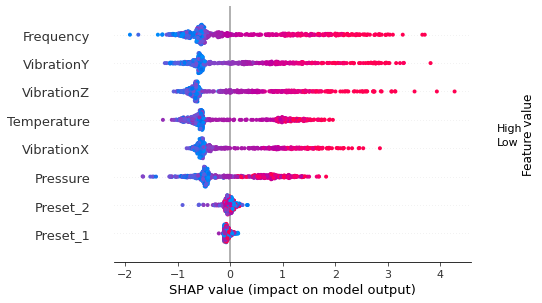

In [69]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(Pool(X_train, y_train, cat_features=cat_features))
shap.summary_plot(shap_values, X_train)